# Mining Detection - Finding new Water Bodies
This notebook finds area with new water bodies, which are often a proxy for active mining. A region is selected and two time regions are selected. Pixels that have NO water in the first time window and then show NEW water in the second time window are identified. This algorithm uses the Australian WOFS water detection algorithm. For more information on WOFS, visit this website: http://www.ga.gov.au/scientific-topics/hazards/flood/wofs

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import xarray as xr
 
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi

In [2]:
api = DataAccessApi(config = '/home/localuser/.datacube.conf')
dc = api.dc

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

In [3]:
# These are the platforms (satellites) and 
# products (datacube sets) used for this demonstration.

# platform = 'LANDSAT_7'
# product = 'ls7_ledaps_ghana'

platform = 'LANDSAT_8'
product = 'ls8_lasrc_ghana'

# The fraction of the original resolution to use for analysis.
# Use this to control memory consumption and run time.
# Set this to None to not scale the resolution of the data.
frac_res = None

## <span id="extents">Get the Maximum Extents of the Cube [&#9652;](#top)</span>

In [4]:
# Print extents of the Data Cube
extents = api.get_full_dataset_extent(platform = platform, product = product)

latitude_extents = (min(extents['latitude'].values),max(extents['latitude'].values))
longitude_extents = (min(extents['longitude'].values),max(extents['longitude'].values))
time_extents = (min(extents['time'].values),max(extents['time'].values))

print(latitude_extents)
print(longitude_extents)
print(time_extents)

(3.7730589405966173, 11.318637832619382)
(-3.772789446011382, 1.8863273493593828)
(numpy.datetime64('2013-04-13T10:10:55.000000000'), numpy.datetime64('2020-01-27T10:09:38.000000000'))


In [5]:
from utils.data_cube_utilities.dc_display_map import display_map

# Display the total shared area available for these datacube products.
# display_map(latitude = full_lat,longitude = full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [6]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# If your datasets are empty, check which products and time extents you used.
# HINT: Keep your region small (<0.5 deg square) to avoid memory overload issues.
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day).
# This region and time period will be used for the water assessment.

# West of Obuasi, Ghana - SMALL REGION
# lat = (6.2286, 6.2822)
# lon = (-1.9324, -1.8871)

# West of Obuasi, Ghana - LARGE REGION
# Run case from 2015 (year) thru 2019 (first 3 months)
# lat = (6.0985, 6.2675)
# lon = (-2.050, -1.8629)

# Ankobra River Basin = Prestia Sample
# Time periods = 29-Dec-2015 to Jan-2018
# lat = (5.4458, 5.5258 )
# lon = (-2.1792, -2.0886)

# Ankobra River Basin = Entire Bounding Region
lat = (5.198, 5.695)
lon = (-2.275, -1.750)


In [7]:
# Define the two time windows here
# No water from 2013-2014 and then new water after 2014
first_time_window = ("2013-01-01", "2014-12-31")
second_time_window = ("2015-01-01", "2019-12-31")


In [8]:
display_map(lat, lon)

### Determine Where There is No Water in FIRST time window and Water in SECOND time window

**Find pixels with No Water in FIRST time window**

In [9]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']
dataset = dc.load(platform=platform, product=product, 
                  lat=lat, lon=lon, 
                  time=first_time_window, measurements=measurements)
clean_mask = landsat_qa_clean_mask(dataset, platform=platform)

In [10]:
dataset

<xarray.Dataset>
Dimensions:    (latitude: 1845, longitude: 1949, time: 32)
Coordinates:
  * time       (time) datetime64[ns] 2013-04-18T10:29:51 ... 2014-12-26T10:21:58
  * latitude   (latitude) float64 5.695 5.695 5.695 5.694 ... 5.199 5.198 5.198
  * longitude  (longitude) float64 -2.275 -2.275 -2.274 ... -1.751 -1.75 -1.75
Data variables:
    red        (time, latitude, longitude) int16 1479 2235 1774 ... 927 933 1114
    green      (time, latitude, longitude) int16 1585 2292 1884 ... 904 915 1026
    blue       (time, latitude, longitude) int16 1512 2226 1707 ... 549 576 646
    nir        (time, latitude, longitude) int16 4180 4635 4404 ... 2220 2366
    swir1      (time, latitude, longitude) int16 2489 3279 3024 ... 2134 2553
    swir2      (time, latitude, longitude) int16 1517 2207 1914 ... 1308 1667
    pixel_qa   (time, latitude, longitude) int32 480 480 480 480 ... 322 322 322
Attributes:
    crs:      EPSG:4326

In [11]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
from xarray.ufuncs import logical_not as xr_not

water = wofs_classify(dataset, clean_mask.values).wofs
del dataset, clean_mask
water = water.astype(np.float16).where(water != -9999)
not_water = xr_not(water.max('time'))
del water

**Find pixels with NEW water in the SECOND time window**

In [12]:
measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']
dataset = dc.load(platform=platform, product=product, 
                  lat=lat, lon=lon, 
                  time=second_time_window, measurements=measurements)
clean_mask = landsat_qa_clean_mask(dataset, platform=platform)

In [13]:
water = wofs_classify(dataset, clean_mask.values).wofs
del dataset, clean_mask
water = water.astype(np.float16).where(water != -9999)
water_after = water.max('time')
del water

### Merge the Masks and Clip the Shapefile

In [14]:
from xarray.ufuncs import logical_and as xr_and
not_water_then_water = xr_and(not_water, water_after)

In [15]:
SHAPE_FILE_PATH = "data/Ghana/Prestea.shp"

In [16]:
import fiona
import xarray as xr 
from rasterio.features import geometry_mask
import shapely
from shapely.ops import transform
from shapely.geometry import shape
from functools import partial
import pyproj

def shapefile_mask(dataset: xr.Dataset, shapefile) -> np.array:
    """Extracts a mask from a shapefile using dataset latitude and longitude extents.

    Args:
        dataset (xarray.Dataset): The dataset with the latitude and longitude extents.
        shapefile (string): The shapefile to be used for extraction.

    Returns:
        A boolean mask array.
    """
    with fiona.open(shapefile, 'r') as source:
        collection = list(source)
        geometries = []
        for feature in collection:
            geom = shape(feature['geometry'])
            project = partial(
                pyproj.transform,
                pyproj.Proj(init=source.crs['init']), # source crs
                pyproj.Proj(init='epsg:4326')) # destination crs
            geom = transform(project, geom)  # apply projection
            geometries.append(geom)
        geobox = dataset.geobox
        mask = geometry_mask(
            geometries,
            out_shape=geobox.shape,
            transform=geobox.affine,
            all_touched=True,
            invert=True)
    return mask

In [17]:
measurements = ['nir']
dataset = dc.load(platform=platform, product=product, lat=lat, lon=lon, 
                  time=second_time_window, measurements=measurements)
mask = shapefile_mask(dataset, SHAPE_FILE_PATH)
del dataset
not_water_then_water = not_water_then_water.where(mask)

### Plot the Final Results

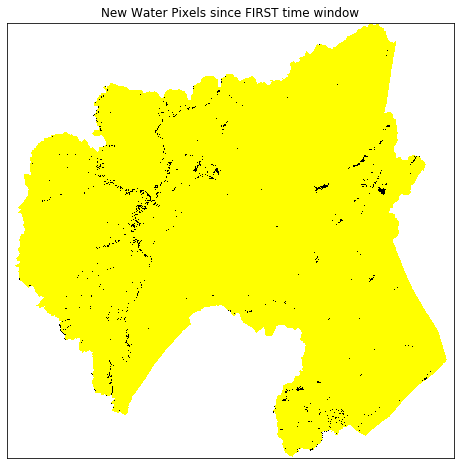

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
not_water_then_water.plot.imshow(cmap='gnuplot_r', vmin=0, vmax=1, add_colorbar=False)
ax.set_title('New Water Pixels since FIRST time window'), ax.xaxis.set_visible(False), ax.yaxis.set_visible(False)
plt.show()

### WOFS Water Counts

In [19]:
# WOFS value for water = 0.0 or 1.0
# The threshold uses a range of 0.99 to 1.01 to identify water (1.0)

wofs_minimum_threshold = 0.99
wofs_maximum_threshold = 1.01

In [20]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))

In [21]:
# COUNT = number of pixels in each category
# INSIDE = Number of water pixels 
threshold_count(not_water_then_water,wofs_minimum_threshold,wofs_maximum_threshold)

{'total': 3595905,
 'total_non_cloudy': 2039207,
 'inside': 21154,
 'outside': 2018053}

### GeoTIFF Output Products

In [22]:
from utils_special.data_cube_utilities.import_export import export_xarray_to_geotiff

# Remove the comment to create a GeoTIFF output product
# Change the name of the output file, or it will be overwritten for each run 

#!rm 'geotiffs/new_water_case1_del.tif'
export_xarray_to_geotiff(data=not_water_then_water.fillna(2).astype(np.uint8),
                         tif_path='geotiffs/new_water_case1_fix.tif',no_data=2)

In [23]:
# !ls -lah geotiffs/*.tif